In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

%matplotlib inline

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using plaidml.keras.backend backend.


In [2]:
start_date = datetime.datetime(2005, 2, 1)
end_date = datetime.datetime(2020, 3, 30)  # move these dates to a utility or constants file and import

In [3]:
def date_filter(df, date_col):
    return df.loc[(df[date_col] >= start_date) & (df[date_col] <= end_date)]

In [4]:
def load_weather_data():
    df = pd.read_csv('../data/central_park_weather_data.csv', dtype='object')
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['weekday'] = df.DATE.dt.weekday
    df['week'] = df.DATE.dt.week
    df['month'] = df.DATE.dt.month
    df['year'] = df.DATE.dt.year
    df['TMAX'] = df['TMAX'].astype('float')
    df['TMIN'] = df['TMIN'].astype('float')
    df['PRCP'] = df['PRCP'].astype('float')
    df = date_filter(df, 'DATE')
    return df

In [5]:
weather = load_weather_data()
weather.set_index('DATE', inplace=True)
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,ACMH,ACMH_ATTRIBUTES,ACSH,ACSH_ATTRIBUTES,AWND,...,WT19,WT19_ATTRIBUTES,WT21,WT21_ATTRIBUTES,WT22,WT22_ATTRIBUTES,weekday,week,month,year
DATE,,,,,,,,,,,,,,,,,,,,,
2005-02-01,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,NaN,NaN,NaN,NaN,2.68,...,NaN,NaN,NaN,NaN,NaN,NaN,1,5,2,2005
2005-02-02,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,NaN,NaN,NaN,NaN,5.14,...,NaN,NaN,NaN,NaN,NaN,NaN,2,5,2,2005
2005-02-03,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,NaN,NaN,NaN,NaN,7.61,...,1,",,X",NaN,NaN,NaN,NaN,3,5,2,2005
2005-02-04,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,NaN,NaN,NaN,NaN,6.71,...,1,",,X",NaN,NaN,NaN,NaN,4,5,2,2005
2005-02-05,USW00094728,"NY CITY CENTRAL PARK, NY US",40.77898,-73.96925,42.7,NaN,NaN,NaN,NaN,6.26,...,NaN,NaN,NaN,NaN,NaN,NaN,5,5,2,2005


In [6]:
def load_pal_data():
    df = pd.read_csv('../data/nyiso_pal_master.csv')
    df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
    df.drop(['Name', 'PTID'], axis=1, inplace=True)
    df.rename(columns={'min': 'pal_min', 'max': 'pal_max', 'mean': 'pal_mean'}, inplace=True)
    return df

In [7]:
pal = date_filter(load_pal_data(), 'Time Stamp')
pal.set_index('Time Stamp', inplace=True)
pal.head()

,pal_min,pal_max,pal_mean
Time Stamp,,,
2011-04-01,4327.3,6665.2,5804.383624
2011-04-02,4320.8,5717.3,5142.040625
2011-04-03,4181.5,5691.4,4982.166436
2011-04-04,4144.2,6461.6,5643.067474
2011-04-05,4143.5,6566.4,5682.628819


In [8]:
merged = pal.join(weather, how='inner')
merged.shape

(5513, 114)

In [9]:
merged.drop(merged.columns[merged.isna().any()].tolist(), axis=1, inplace=True)

In [10]:
merged.columns


Index(['pal_min', 'pal_max', 'pal_mean', 'STATION', 'NAME', 'LATITUDE',
       'LONGITUDE', 'ELEVATION', 'PRCP', 'PRCP_ATTRIBUTES', 'SNWD',
       'SNWD_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN', 'TMIN_ATTRIBUTES',
       'weekday', 'week', 'month', 'year'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['PRCP', 'SNWD', 'TMAX', 'TMIN', 'weekday', 'week', 'month', 'year']
target = ['pal_mean']

y = merged[target]
X = merged[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Score: 0.42943673189396503


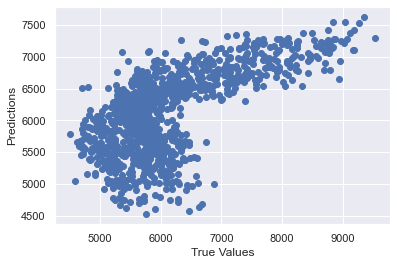

In [12]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

print(f'Score: {model.score(X_test, y_test)}')

#### Interesting. 43% score matches the first epoch in the loss function of our Keras NN. Is this related?

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # get number of PC to ensure 95% of variance captured
pca.fit(X_train)

# apply
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
pca.n_components_

6

Score: 0.40864246585720065


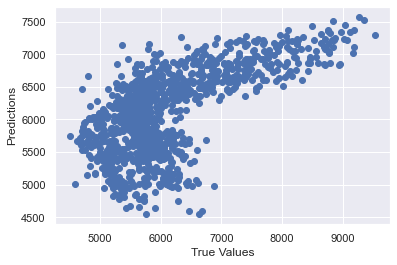

In [14]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

print(f'Score: {model.score(X_test, y_test)}')

#### PCA actually lowers our predictive ability. This implies we need more features? 